In [1]:
import os
import numpy as np 
from sklearn.model_selection import KFold  # 라벨 x_data, y_data 분포를 유지 (함께 fold)

from IPython.display import clear_output

np.random.seed(7)
np.set_printoptions(precision=4, suppress=True)  # 과학적 표기 대신 소숫점 자리 4자리까지 표현

rootDir = "D:/바탕화면/Dataset/TUG/trainSet"
expertFolder = "/" + "2021_01_24_saveResults_최윤정"  # --- 변경 할 부분
viewFolder = "/" + "0_sideView"

print(" [Home Dir.] Current path", os.getcwd())  

datasetDir = rootDir + expertFolder + viewFolder
os.chdir(datasetDir) ; print(" Current workaing path [dataset] ", os.getcwd())  # -- Dataset 있는 곳으로 경로 변경 

 [Home Dir.] Current path D:\바탕화면\conda\tug\own\tug-main\0_temporalCNN_wLabel
 Current workaing path [dataset]  D:\바탕화면\Dataset\TUG\trainSet\2021_01_24_saveResults_최윤정\0_sideView


In [2]:
def trainData_split(datasetDir,train_ratio = 0.6, valid_ratio=0.2, shuffle = False,  Kfold_num = 5):      
    expDates = next(os.walk(datasetDir))[1]   #['2020_11_03', '2020_11_20_v1', '2020_11_20_v2', '2020_11_23', '2020_12_09', '2020_12_30']
    
    subject_number = 0
    subjects_list = []
    
    for dateFolder in expDates:
        dateDir = os.path.join(datasetDir, dateFolder)   # D:/바탕화면/Dataset/TUG/trainSet/2021_01_24_saveResults_최윤정/0_sideView\2020_11_03
        tmpSubjects = next(os.walk(dateDir))[1]
        subjects_list.append(tmpSubjects)  
        subject_number += len(tmpSubjects)

    # ------ 2D -> 1D [[sub1, sub2], [sub3, sub4]] -> [sub1, sub2, sub3, sub4]
    subjects = []
    for eachSub in subjects_list:
        subjects += eachSub
    print(" [before shuffle] 1D sub list: " , subjects)

    if shuffle:
        np.random.shuffle(subjects)
        print(" [After shuffle] 1D sub list: " , subjects)
            

#     # --- K-fold cross validation
    
    if Kfold_num is not 0:
        Fold_results =[]
        print(" [K-Fold] K = ", Kfold_num)
        kfold = KFold(n_splits=  Kfold_num)
        for trainIdx, testIdx in kfold.split(subjects):
            Fold_results.append([trainIdx, testIdx])        
        train_Fold= []
        test_Fold = []
        
        for i in range(Kfold_num):
            tmp_train = []
            tmp_test = []
            for subIdx in range(len(subjects)): 
                if subIdx in Fold_results[i][0]:  # 
                    tmp_train.append(subjects[subIdx])
                    
                if subIdx in Fold_results[i][1]:  # -- K-fold test
                    tmp_test.append(subjects[subIdx])
          
            train_Fold.append(tmp_train)
            test_Fold.append(tmp_test)
            print("\t [process]", i, "-fold:", train_Fold[i], "\n\t\t\t   ,", test_Fold[i])
        print("\n [results]  trainSet: ", len(train_Fold[0]) , " 명 , testSet: ", len(test_Fold[0]), " 명" )
        return train_Fold, test_Fold

        
    else:
                # ---- Split train/test subjects (for arbitrary split)
        trainSub_number = np.round( (len(subjects)*train_ratio), 0).astype(int)
        validSub_number = np.round( (len(subjects)*valid_ratio), 0).astype(int)
        testSub_number = subject_number - trainSub_number - validSub_number
        
        print("--------- no fold ----")
        train_subjects = subjects[ :trainSub_number]
        valid_subjects = subjects[ trainSub_number : (trainSub_number+validSub_number)]
        test_subjects = subjects[ (trainSub_number+validSub_number): ]
        print("[results] \n\t Train: " ,train_subjects, "\n\t Valid: ", valid_subjects, "\n\t Test: ", test_subjects)
        print("\n\t--> # of train  : " + str(trainSub_number) +" 명 ,  # of valid : "+ str(validSub_number) + " 명 ,  # of test :" + str(testSub_number) + "명")
        return train_subjects, valid_subjects, test_subjects 


def getPelvisData(csvFile):
    rawData = np.loadtxt(csvFile, delimiter=",")
    timestamp = rawData[:,0]
    pelvis_x = rawData[:,1]
    pelvis_y = rawData[:,2]
    pelvis_z = rawData[:,3]
    actionList = rawData[:,4:9]
    return timestamp, pelvis_x, pelvis_y, pelvis_z, actionList

def create_dataset(train_subjects, valid_subjects, test_subjects):
    train_x = np.zeros((0, numFeature))
    train_y = np.zeros((0, numActions))
    
    valid_x = np.zeros((0, numFeature))
    valid_y = np.zeros((0, numActions))
    
    test_x = np.zeros((0, numFeature))
    test_y = np.zeros((0, numActions))    
    
    for dirpath, foldername, files in os.walk(datasetDir):
        for filename in files:
            if "lpf_" in filename:
                subname = dirpath.split("\\")[2] 
                csvFile = os.path.join(dirpath, filename)
                timestamp, pelvis_x, pelvis_y, pelvis_z, actionList = getPelvisData(csvFile) 
                
                pelvisData = np.array([pelvis_x, pelvis_y, pelvis_z]).T
                actionData = np.array(actionList)
                #dataset = tf.data.Dataset.from_tensor_slices( (pelvisData.astype('float32'), actionData.astype('float32')) ) 
                dataset = np.zeros( (len(pelvisData), dataset_columns) ) 
                
                dataset[:, :-(numActions)] = pelvisData      # time , pelvis  넣음  (317,4) -- raw data 
                dataset[:, -(numActions): ] = actionData     # (335, 5) one hot encoding 수행한 actionsList
                
                if Kfold_num==0:
                    if subname in train_subjects:
                        train_x = np.append(train_x, pelvisData, axis = 0 )
                        train_y = np.append(train_y, actionData, axis = 0 )

                    elif subname in valid_subjects:
                        valid_x = np.append(valid_x, pelvisData, axis = 0 )
                        valid_y = np.append(valid_y, actionData, axis = 0 )

                    elif subname in test_subjects:
                        test_x = np.append(test_x, pelvisData, axis = 0 )
                        test_y = np.append(test_y, actionData, axis = 0 )    
                else:
                    if subname in train_subjects:
                        train_x = np.append(train_x, pelvisData, axis = 0 )
                        train_y = np.append(train_y, actionData, axis = 0 )
                    elif subname in test_subjects:
                        test_x = np.append(test_x, pelvisData, axis = 0 )
                        test_y = np.append(test_y, actionData, axis = 0 )   

    return train_x, train_y, valid_x, valid_y, test_x, test_y 



In [3]:
# ---------------  1. subject 별로 dataset 분할 (K-fold 정함) ------------------------------------------------------#

train_ratio = 0.6
valid_ratio = 0.2

Kfold_num = 0 # if kfold_num = 0 (arbitrary train/test set will be used)s
arbitrary_dataset = True

numFeature = 3
numActions = 5
dataset_columns = numFeature + numActions

if Kfold_num == 0:
    if arbitrary_dataset:

#         normal_subjects = ['bys_tug', 'cbd_tug', 'cyj_tug', 'kw', 'kyh', 'lhs', 'NHJ_60', 'nhs', 'pjh', 'pss', 'rjh', 'yjh', 'bys', 'cbd', 'cyj', 'cyj2', 'jdh', 'jek', 'kch', 'ryu'] 
#         patients_subjects = ['JDW_tug']
#         copy_patients_subjects = ['BYS_TUG', 'CYJ_TUG', 'PHE_TUG', 'YSJ_TUG'] 


        train_subjects = ['bys_tug', 'cbd_tug', 'cyj_tug', 'kw', 'kyh', 'nhs', 'pjh', 'pss', 'rjh', 'yjh', 'bys', 'cbd', 'cyj','BYS_TUG', 'CYJ_TUG'] 
        valid_subjects = ['cyj2', 'jdh', 'jek', 'PHE_TUG','lhs' ] 
        test_subjects =  ['kch', 'ryu', 'JDW_tug', 'YSJ_TUG','NHJ_60']
    else:
        train_subjects, valid_subjects, test_subjects = trainData_split(datasetDir, train_ratio = train_ratio, valid_ratio=valid_ratio, shuffle = False, Kfold_num = Kfold_num)
        
    train_x, train_y, valid_x, valid_y, test_x, test_y = create_dataset(train_subjects, valid_subjects, test_subjects )
    print("\n [Train] X - {0} , Y - {1} \t [Valid] X - {2}, Y - {3} \t [Test] X - {4} , Y - {5}".format(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape, test_y.shape))
    
else: 
    train_fold, test_fold = trainData_split(datasetDir, shuffle = False, Kfold_num = Kfold_num) 
    print("\n\n -------------------- K-Fold Dataset ------------------------ ")
    folds_dataset = []
    for i in range(Kfold_num):
        train_x, train_y, test_x, test_y = create_dataset(train_fold[i])
        print(" \t Train (X,Y): {0} , {1} \t Test (X,Y): {2} , {3}".format(train_x.shape, train_y.shape, test_x.shape, test_y.shape))
        folds.append((train_x, train_y, test_x, test_y)) # --- 수정 필요할듯
    print(np.array(folds[0][0]).shape)


 [Train] X - (65618, 3) , Y - (65618, 5) 	 [Valid] X - (21296, 3), Y - (21296, 5) 	 [Test] X - (18810, 3) , Y - (18810, 5)


In [4]:
x_train = train_x.reshape(-1, 1, 3)
x_valid = valid_x.reshape(-1, 1, 3)
x_test = test_x.reshape(-1, 1, 3)

y_train = np.expand_dims(train_y, axis=2)
y_valid = np.expand_dims(valid_y, axis=2)
y_test = np.expand_dims(test_y, axis=2)

print("\n [Train] X - {0} , Y - {1} \t [Valid] X - {2}, Y - {3} \t [Test] X - {4} , Y - {5}".format(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape))


 [Train] X - (65618, 1, 3) , Y - (65618, 5, 1) 	 [Valid] X - (21296, 1, 3), Y - (21296, 5, 1) 	 [Test] X - (18810, 1, 3) , Y - (18810, 5, 1)


In [5]:
from tcn import TCN, compiled_tcn

model = compiled_tcn(return_sequences=False,
                         num_feat=3,
                         num_classes=5,
                         nb_filters=20,
                         kernel_size=6,
                         dilations=[2 ** i for i in range(9)],
                         nb_stacks=1,
                         max_len=x_train[0:1].shape[1],
                         use_skip_connections=True)

print("\n")
model.summary()

x.shape= (None, 20)
model.x = (None, 1, 3)
model.y = (None, 5)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 3)]            0         
_________________________________________________________________
tcn (TCN)                    (None, 20)                41600     
_________________________________________________________________
dense (Dense)                (None, 5)                 105       
_________________________________________________________________
activation (Activation)      (None, 5)                 0         
Total params: 41,705
Trainable params: 41,705
Non-trainable params: 0
_________________________________________________________________


In [6]:
print(f'x_train.shape = {x_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'x_test.shape = {x_test.shape}')
print(f'y_test.shape = {y_test.shape}')


y_train = y_train.squeeze().argmax(axis=1)
y_test = y_test.squeeze().argmax(axis=1)
print(y_train)

x_train.shape = (65618, 1, 3)
y_train.shape = (65618, 5, 1)
x_test.shape = (18810, 1, 3)
y_test.shape = (18810, 5, 1)
[0 0 0 ... 0 0 0]


In [7]:
history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test), workers=4, use_multiprocessing=True)

Epoch 1/10
2051/2051 [==============================] - 41s 20ms/step - loss: 0.5811 - accuracy: 0.7589 - val_loss: 0.5872 - val_accuracy: 0.7570
Epoch 2/10
2051/2051 [==============================] - 40s 20ms/step - loss: 0.5334 - accuracy: 0.7708 - val_loss: 0.5992 - val_accuracy: 0.7628
Epoch 3/10
2051/2051 [==============================] - 40s 20ms/step - loss: 0.5186 - accuracy: 0.7770 - val_loss: 0.6117 - val_accuracy: 0.7561
Epoch 4/10
2051/2051 [==============================] - 40s 20ms/step - loss: 0.5107 - accuracy: 0.7813 - val_loss: 0.6043 - val_accuracy: 0.7548
Epoch 5/10
2051/2051 [==============================] - 40s 20ms/step - loss: 0.5072 - accuracy: 0.7815 - val_loss: 0.6082 - val_accuracy: 0.7611
Epoch 6/10
2051/2051 [==============================] - 40s 20ms/step - loss: 0.5026 - accuracy: 0.7836 - val_loss: 0.5976 - val_accuracy: 0.7559
Epoch 7/10
2051/2051 [==============================] - 40s 19ms/step - loss: 0.4992 - accuracy: 0.7839 - val_loss: 0.6883 -

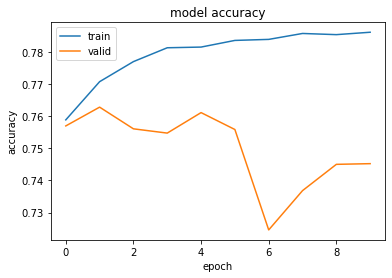

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")

plt.legend(["train","valid"], loc= "upper left")
plt.show()


In [11]:
from sklearn.preprocessing import MinMaxScaler
import tqdm

lookback_window = 8

def sliding_window(data_x, data_y, lookback_window=15):
    x = []
    y = []
    enc = MinMaxScaler(feature_range = (0, 1))
    enc_y = enc.fit_transform(data_y)
    for i in range(lookback_window, len(data_x)):
        x.append(data_x[i - lookback_window:i])
        y.append(data_y[i])
        
    x = np.array(x)
    y = np.array(y)
    return x, y, enc


x_train, y_train, enc_train = sliding_window(train_x, train_y,  lookback_window=lookback_window) # (57207, 15, 3)
x_valid, y_valid, enc_valid = sliding_window(valid_x, valid_y,  lookback_window=lookback_window)
x_test, y_test, enc_test = sliding_window(test_x, test_y, lookback_window=lookback_window)
print("x_train: ", x_train.shape," , y_train: ", y_train.shape)
print("x_valid: ",x_valid.shape, " , y_valid: ",y_valid.shape)
print("x_test: ",x_test.shape, "  , y_test: ",y_test.shape)


x_train:  (65615, 3, 3)  , y_train:  (65615, 5)
x_valid:  (21293, 3, 3)  , y_valid:  (21293, 5)
x_test:  (18807, 3, 3)   , y_test:  (18807, 5)


### Model Build

In [12]:
from keras.layers import Conv1D, Input, Activation, Flatten, Dense, Conv2D
from keras.layers import BatchNormalization, add , Dropout
from keras.models import Model
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping

from tcn import TCN

In [14]:
i = Input(shape=(lookback_window, 3))
m = TCN()(i)
m = Dense(5, activation='softmax')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()

model.compile('adam','categorical_crossentropy')

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 3)]            0         
_________________________________________________________________
tcn_1 (TCN)                  (None, 64)                91520     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 91,845
Trainable params: 91,845
Non-trainable params: 0
_________________________________________________________________


In [15]:
print('Train...')
model.fit(x_train, y_train, epochs=100)

Train...
Epoch 1/100
2051/2051 [==============================] - 8s 4ms/step - loss: 0.3950
Epoch 2/100
2051/2051 [==============================] - 8s 4ms/step - loss: 0.2474
Epoch 3/100
2051/2051 [==============================] - 8s 4ms/step - loss: 0.2261
Epoch 4/100
2051/2051 [==============================] - 8s 4ms/step - loss: 0.2137
Epoch 5/100
2051/2051 [==============================] - 8s 4ms/step - loss: 0.2035
Epoch 6/100
 263/2051 [==>...........................] - ETA: 7s - loss: 0.2039

KeyboardInterrupt: 